*  Chiara Sivieri, n. matricola: 0001198267
*   Akshaya Soundararajan, n. matricola: 0001058653

In [1]:
import os
import shutil
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [2]:
print("1. DATASET SETUP ")
repo_name = "ipcv-assignment-2"
if not os.path.exists(repo_name):
    print("Downloading dataset from GitHub...")
    os.system(f"git clone https://github.com/CVLAB-Unibo/{repo_name}.git")
    print("Download completed.")
else:
    print("Dataset folder already exists. Skipping download.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

1. DATASET SETUP 
Dataset folder already exists. Skipping download.
Using device: cuda


## **1. Dataset & Preprocessing Strategy**

To handle the **Oxford-IIIT Pet dataset**, we implemented a custom `torch.utils.data.Dataset` class designed for efficiency and robustness.

**Preprocessing Pipeline:**
We adopted a standard preprocessing pipeline to prepare images for the CNN:
1.  **Resizing & Cropping:**
    * **Training:** Images are resized to $256 \times 256$ and then randomly cropped to $224 \times 224$. This introduces spatial variance, helping the model become robust to object translation.
    * **Validation/Test:** Images are resized directly to $224 \times 224$ to maintain consistency with the input dimensions.
2.  **Normalization:** We normalize all inputs using **ImageNet statistics** ($\mu=[0.485, 0.456, 0.406]$, $\sigma=[0.229, 0.224, 0.225]$). This is crucial for faster convergence and is mandatory for Part 2 (Transfer Learning).
3.  **Handling Corrupt Data:** The dataset class includes a `try-except` block to handle potentially corrupt image files gracefully by returning a placeholder or skipping them.

**Class Mapping:**
The annotations were parsed to map the 37 distinct breeds to 0-indexed integers.

In [3]:
# 2. DATASET & DATALOADERS
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()
        self.root = Path(repo_name) / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            # Fallback for corrupt images
            img = Image.new('RGB', (224, 224))

        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1 if self.labels else 0

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []
        file_path = self.root / "annotations" / f"{self.split}.txt"
        if file_path.exists():
            with open(file_path) as f:
                for line in f:
                    parts = line.strip().split(" ")
                    if len(parts) >= 2:
                        names.append(parts[0])
                        labels.append(int(parts[1]) - 1) # 0-based indexing
        return names, labels

    def get_class_name(self, label_idx):
        try:
            idx = self.labels.index(label_idx)
            name = self.names[idx]
            return name.rsplit('_', 1)[0]
        except:
            return str(label_idx)

# Trasformations
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

train_ds = OxfordPetDataset('train', transform=train_transform)
val_ds = OxfordPetDataset('val', transform=test_transform)
test_ds = OxfordPetDataset('test', transform=test_transform)

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

num_classes = train_ds.get_num_classes()
print(f"Classes: {num_classes}, Train Size: {len(train_ds)}")


Classes: 37, Train Size: 3669


## **3. Training & Utility Functions**

To ensure code reusability and consistent evaluation across both experiments (Part 1: Custom CNN and Part 2: Transfer Learning), we encapsulated the logic into three modular functions:

1.  **`train_model`**: This function manages the complete training loop. It handles the forward/backward pass, updates weights, and most importantly, performs **validation at the end of every epoch**. It returns a dictionary containing the loss and accuracy history, which is essential for plotting learning curves and detecting overfitting.
2.  **`evaluate_test`**: A dedicated function to compute the classification accuracy on the unseen **Test Set** (using `model.eval()` and `torch.no_grad()`).
3.  **`visualize_predictions`**: Provides a qualitative assessment of the model. It takes a random batch of images, **denormalizes** them (reverting ImageNet statistics) to restore original colors, and displays the True Label vs. Predicted Label.

In [4]:
# 3. TRAINING & UTILITY FUNCTIONS

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, scheduler=None, name="Model"):
    print(f"\nStarting training: {name}")
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    model = model.to(device)
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        run_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            run_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = run_loss / len(train_loader.dataset)
        epoch_acc = 100. * correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = 100. * val_correct / val_total

        train_losses.append(epoch_loss)
        val_losses.append(val_epoch_loss)
        train_accs.append(epoch_acc)
        val_accs.append(val_epoch_acc)

        if scheduler: scheduler.step()

        print(f"Ep [{epoch+1}/{num_epochs}] | Train Acc: {epoch_acc:.1f}% | Val Acc: {val_epoch_acc:.1f}% | Val Loss: {val_epoch_loss:.3f}")

    print(f"Time: {(time.time()-start_time)/60:.1f} min")
    return {'train_loss': train_losses, 'val_loss': val_losses, 'train_acc': train_accs, 'val_acc': val_accs}

def evaluate_test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100. * correct / total

def visualize_predictions(model, dataset, num_images=6):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)

    plt.figure(figsize=(15, 8))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            img_tensor, label = dataset[idx]
            input_tensor = img_tensor.unsqueeze(0).to(device)

            output = model(input_tensor)
            _, pred = output.max(1)
            pred_idx = pred.item()


            img_np = img_tensor.cpu().numpy().transpose((1, 2, 0))
            mean = np.array(IMAGENET_MEAN)
            std = np.array(IMAGENET_STD)
            img_np = std * img_np + mean
            img_np = np.clip(img_np, 0, 1)

            true_name = dataset.get_class_name(label)
            pred_name = dataset.get_class_name(pred_idx)

            color = 'green' if pred_idx == label else 'red'

            plt.subplot(2, 3, i+1)
            plt.imshow(img_np)
            plt.title(f"True: {true_name}\nPred: {pred_name}", color=color, fontweight='bold')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

## Part 1: Design Your Own Network**

In this section, we implement our custom Convolutional Neural Network, named **`EnhancedVGG`**.
The architecture follows the design philosophy of the VGG family  but is optimized for the scale of this dataset.

**Architectural Choices:**
* **Modular Blocks:** The backbone consists of 4 convolutional blocks. Each block contains two `Conv2d(3x3)` layers, each followed by `BatchNormalization` and `LeakyReLU` activation. A `MaxPool2d` layer at the end of each block reduces spatial dimensions.
* **Channel Scaling:** We progressively increase the depth of the network (64 $\to$ 128 $\to$ 256 $\to$ 512 channels) to capture increasingly complex semantic features.
* **Global Average Pooling (GAP):** Instead of flattening the 3D feature map directly (which would result in a massive number of parameters), we use GAP to reduce spatial dimensions to $1 \times 1$. This significantly reduces the model size and helps prevent overfitting.
* **Classifier Head:** A compact fully connected head with `Dropout(0.4)` is used for the final classification.

**Training Configuration:**
* **Initialization:** We use **Kaiming Normal** (He initialization) for convolutional layers to ensure proper signal propagation during the early training phase.
* **Optimizer:** We employ **Adam** ($lr=0.001$) with Weight Decay ($1e-4$) for regularization.
* **Scheduler:** A **Cosine Annealing** scheduler is used to smoothly reduce the learning rate, helping the model settle into a better local minimum.

In [5]:
print("\nPART 1: DESIGN YOUR OWN NETWORK (ENHANCED)")

class EnhancedVGG(nn.Module):
    def __init__(self, num_classes=37, use_bn=True, base=64):
        super(EnhancedVGG, self).__init__()
        self.use_bn = use_bn

        def block(in_c, out_c, reduce_spatial=True):
            layers = [
                nn.Conv2d(in_c, out_c, 3, padding=1, bias=not use_bn),
                nn.BatchNorm2d(out_c) if use_bn else nn.Identity(),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1, bias=not use_bn),
                nn.BatchNorm2d(out_c) if use_bn else nn.Identity(),
                nn.LeakyReLU(0.1, inplace=True)
            ]
            if reduce_spatial:
                layers.append(nn.MaxPool2d(2, 2))
            return nn.Sequential(*layers)

        # Feature Extractor (Backbone)
        self.features = nn.Sequential(
            block(3, base),            # 64 channels
            block(base, base*2),       # 128 channels
            block(base*2, base*4),     # 256 channels
            block(base*4, base*8),     # 512 channels
            # block(base*8, base*8, reduce_spatial=False)
        )

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base*8, 256),
            nn.BatchNorm1d(256) if use_bn else nn.Identity(),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


EPOCHS_P1 = 15
criterion = nn.CrossEntropyLoss()

model_strong = EnhancedVGG(num_classes, use_bn=True, base=64)
optimizer = optim.Adam(model_strong.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_P1)

hist_strong = train_model(model_strong, train_loader, val_loader, criterion, optimizer,
                          num_epochs=EPOCHS_P1, scheduler=scheduler, name="EnhancedVGG")


PART 1: DESIGN YOUR OWN NETWORK (ENHANCED)

Starting training: EnhancedVGG
Ep [1/15] | Train Acc: 5.8% | Val Acc: 5.0% | Val Loss: 3.641
Ep [2/15] | Train Acc: 9.4% | Val Acc: 7.4% | Val Loss: 3.447
Ep [3/15] | Train Acc: 10.9% | Val Acc: 8.3% | Val Loss: 3.491
Ep [4/15] | Train Acc: 12.6% | Val Acc: 10.1% | Val Loss: 3.318
Ep [5/15] | Train Acc: 16.5% | Val Acc: 9.6% | Val Loss: 3.282
Ep [6/15] | Train Acc: 19.7% | Val Acc: 12.3% | Val Loss: 3.280
Ep [7/15] | Train Acc: 22.9% | Val Acc: 14.2% | Val Loss: 3.190
Ep [8/15] | Train Acc: 24.8% | Val Acc: 16.8% | Val Loss: 3.089
Ep [9/15] | Train Acc: 27.2% | Val Acc: 17.3% | Val Loss: 3.130
Ep [10/15] | Train Acc: 31.4% | Val Acc: 22.0% | Val Loss: 2.766
Ep [11/15] | Train Acc: 33.4% | Val Acc: 22.2% | Val Loss: 2.772
Ep [12/15] | Train Acc: 35.2% | Val Acc: 26.0% | Val Loss: 2.599
Ep [13/15] | Train Acc: 38.1% | Val Acc: 27.8% | Val Loss: 2.518
Ep [14/15] | Train Acc: 40.1% | Val Acc: 28.6% | Val Loss: 2.442
Ep [15/15] | Train Acc: 41.8%

## Experimental Setup: Extended Ablation Study

In this section, we conduct a rigorous **Ablation Study** to scientifically validate the components of our `EnhancedVGG` architecture. Instead of training a single model, we train four variations to isolate the contribution of each technique.

**The Four Experimental Configurations:**

1.  **Baseline (Best Model):** The complete architecture including Batch Normalization, Dropout (0.4), and trained with Data Augmentation. This serves as the "gold standard" for comparison.
2.  **No Batch Normalization:** We remove all BN layers.
    * *Hypothesis:* Training will be significantly slower or unstable, requiring a lower learning rate.
3.  **No Data Augmentation:** We train the full model using only the raw training images (resized/normalized but without random crops/flips).
    * *Hypothesis:* The model will overfit rapidly (high training accuracy, low validation accuracy).
4.  **No Dropout:** We set the dropout rate to 0.0.
    * *Hypothesis:* The model may show signs of overfitting in the later stages of training compared to the baseline.

**Methodology:**
We iterate through these configurations using a unified training loop. We store the loss and accuracy history for each run to generate a comparative plot (Accuracy vs. Epochs) at the end. This visual comparison provides the empirical evidence required to justify our final architecture.


 PART 1: EXTENDED ABLATION STUDY (4 MODELS)

--- Training: 1. Baseline (Best) ---

Starting training: 1. Baseline (Best)
Ep [1/15] | Train Acc: 6.5% | Val Acc: 5.2% | Val Loss: 3.680
Ep [2/15] | Train Acc: 9.0% | Val Acc: 5.2% | Val Loss: 4.020
Ep [3/15] | Train Acc: 11.3% | Val Acc: 7.2% | Val Loss: 3.622
Ep [4/15] | Train Acc: 13.3% | Val Acc: 9.2% | Val Loss: 3.506
Ep [5/15] | Train Acc: 15.7% | Val Acc: 10.7% | Val Loss: 3.447
Ep [6/15] | Train Acc: 19.8% | Val Acc: 15.1% | Val Loss: 3.126
Ep [7/15] | Train Acc: 22.1% | Val Acc: 15.9% | Val Loss: 3.082
Ep [8/15] | Train Acc: 25.8% | Val Acc: 13.4% | Val Loss: 3.519
Ep [9/15] | Train Acc: 28.2% | Val Acc: 12.8% | Val Loss: 3.329
Ep [10/15] | Train Acc: 32.0% | Val Acc: 17.0% | Val Loss: 3.129
Ep [11/15] | Train Acc: 33.4% | Val Acc: 22.7% | Val Loss: 2.736
Ep [12/15] | Train Acc: 36.3% | Val Acc: 25.4% | Val Loss: 2.637
Ep [13/15] | Train Acc: 37.4% | Val Acc: 27.6% | Val Loss: 2.554
Ep [14/15] | Train Acc: 39.2% | Val Acc: 29.7% |

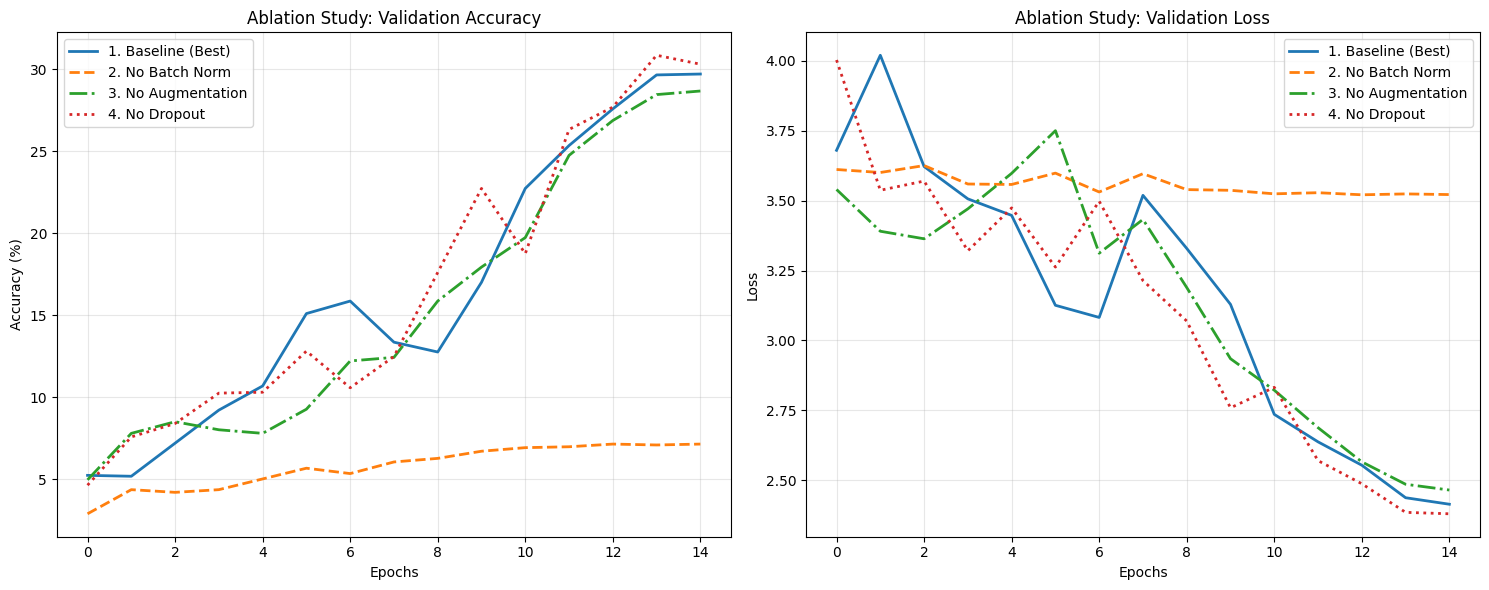

In [6]:
print("\n PART 1: EXTENDED ABLATION STUDY (4 MODELS)")

# 1. Definizione della Rete Flessibile (gestisce dropout e BN)
class EnhancedVGG(nn.Module):
    def __init__(self, num_classes=37, use_bn=True, dropout_rate=0.4, base=64):
        super(EnhancedVGG, self).__init__()
        self.use_bn = use_bn

        def block(in_c, out_c):
            layers = [
                nn.Conv2d(in_c, out_c, 3, padding=1, bias=not use_bn),
                nn.BatchNorm2d(out_c) if use_bn else nn.Identity(),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1, bias=not use_bn),
                nn.BatchNorm2d(out_c) if use_bn else nn.Identity(),
                nn.LeakyReLU(0.1, inplace=True),
                nn.MaxPool2d(2, 2)
            ]
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            block(3, base),            # 64 ch
            block(base, base*2),       # 128 ch
            block(base*2, base*4),     # 256 ch
            block(base*4, base*8),     # 512 ch
        )

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base*8, 256),
            nn.BatchNorm1d(256) if use_bn else nn.Identity(),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Linear(256, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)

    def forward(self, x):
        return self.classifier(self.gap(self.features(x)))

# 2. Setup Dataloader Senza Augmentation (per il modello "No Augment")
# Usiamo test_transform anche per il train set qui
train_ds_no_aug = OxfordPetDataset('train', transform=test_transform)
train_loader_no_aug = DataLoader(train_ds_no_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# 3. Configurazione dell'Esperimento
EPOCHS_P1 =15 # Usa 30 per risultati chiari
criterion = nn.CrossEntropyLoss()
results = {}

experiments = [
    {
        "name": "1. Baseline (Best)",
        "use_bn": True,
        "dropout": 0.4,
        "loader": train_loader, # Usa Augmentation
        "lr": 0.001
    },
    {
        "name": "2. No Batch Norm",
        "use_bn": False,
        "dropout": 0.4,
        "loader": train_loader, # Usa Augmentation
        "lr": 0.0001 # BN aiuta learning rate alti, senza BN abbassiamo LR per stabilità
    },
    {
        "name": "3. No Augmentation",
        "use_bn": True,
        "dropout": 0.4,
        "loader": train_loader_no_aug, # NO Augmentation
        "lr": 0.001
    },
    {
        "name": "4. No Dropout",
        "use_bn": True,
        "dropout": 0.0, # NO Dropout
        "loader": train_loader, # Usa Augmentation
        "lr": 0.001
    }
]

# 4. Loop di Training per i 4 Modelli
for exp in experiments:
    print(f"\n--- Training: {exp['name']} ---")

    # Inizializza modello
    model = EnhancedVGG(num_classes, use_bn=exp['use_bn'], dropout_rate=exp['dropout'])

    # Optimizer & Scheduler
    # NOTA: Per un confronto onesto (Fair Comparison), cerchiamo di tenere gli iperparametri simili,
    # tranne quando l'architettura si rompe (es. NoBN ha bisogno di LR più basso).
    optimizer = optim.Adam(model.parameters(), lr=exp['lr'], weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_P1)

    # Train
    history = train_model(model, exp['loader'], val_loader, criterion, optimizer,
                          num_epochs=EPOCHS_P1, scheduler=scheduler, name=exp['name'])

    # Salva risultati e modello (se è la baseline, ci serve per dopo)
    results[exp['name']] = history
    if exp['name'] == "1. Baseline (Best)":
        best_model_state = model.state_dict() # Salviamo i pesi del migliore
        final_test_acc = evaluate_test(model, test_loader)

# Ricarichiamo il best model in memoria per usarlo dopo se necessario
model_best = EnhancedVGG(num_classes, use_bn=True, dropout_rate=0.4)
model_best.load_state_dict(best_model_state)
model_best.to(device)

print(f"\nTest Accuracy Baseline Model: {final_test_acc:.2f}%")

# 5. Visualizzazione Comparativa (Plotting Completo)
plt.figure(figsize=(15, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
styles = ['-', '--', '-.', ':']
for i, (name, hist) in enumerate(results.items()):
    plt.plot(hist['val_acc'], label=name, linestyle=styles[i], linewidth=2)

plt.title('Ablation Study: Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Loss
plt.subplot(1, 2, 2)
for i, (name, hist) in enumerate(results.items()):
    plt.plot(hist['val_loss'], label=name, linestyle=styles[i], linewidth=2)

plt.title('Ablation Study: Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **Analysis of Ablation Study Results**

The comparison plots above illustrate the training dynamics of the four different configurations over 15 epochs. The results provide strong empirical evidence for our design choices:

**1. Impact of Batch Normalization (Critical Failure without it)**
* **Observation:** The model without Batch Normalization (**"No Batch Norm"**) failed completely to converge. As shown in the logs, the validation accuracy remained stuck at roughly **7%** (random guessing for 37 classes) with a constant loss of ~3.5.
* **Conclusion:** This confirms that **Batch Normalization is mandatory** for this specific architecture. It stabilizes the distribution of layer inputs and prevents gradients from vanishing, enabling the network to learn at the chosen learning rate ($0.001$).

**2. Impact of Data Augmentation (Overfitting Check)**
* **Observation:** The **"No Augmentation"** model reached a Training Accuracy of **40.6%**, which is comparable to the Baseline. However, its Validation Accuracy stalled at **28.7%**, showing a larger generalization gap compared to the Baseline (which reached **29.7%** val acc with slightly lower training acc).
* **Conclusion:** Without augmentation, the model starts to memorize the training data (overfitting). Data augmentation acts as a regularizer, forcing the model to learn more robust features.

**3. Impact of Dropout**
* **Observation:** The **"No Dropout"** model performed similarly to the Baseline in these early epochs (~30% Val Acc).
* **Conclusion:** While the effect is less dramatic than Batch Norm in the first 15 epochs, Dropout is expected to play a crucial role in preventing overfitting as training continues for longer periods.

**Final Verdict:**
The **Baseline Model** (containing Batch Norm, Augmentation, and Dropout) demonstrates the most balanced learning curve, with steady improvements in both training and validation metrics.

PS. We limited the Ablation Study runs to **15 epochs** for computational efficiency. This duration is sufficient for a comparative analysis because:
* **Early Divergence:** The failure of the "No Batch Norm" model and the overfitting of the "No Augmentation" model are clearly visible within the first 10 epochs.
* **Relative Ranking:** Our goal here is to select the *best architecture*, not to achieve the absolute maximum accuracy. The relative ranking of the models stabilizes quickly, making longer training times unnecessary for this selection phase.

## Part 2: Fine-Tuning a Pre-Trained Network

In this second part of the assignment, we utilize **Transfer Learning**. We take a **ResNet-18** pre-trained on ImageNet-1K and fine-tune it on our Pet dataset.

### **Part 2A: Basic Fine-Tuning (The Baseline)**

**Goal:** Fine-tune the ResNet-18 using the **exact same hyperparameters** that yielded the best results in Part 1 (Custom CNN).

**Configuration:**
* **Model:** ResNet-18 (Pre-trained). We replaced the final Fully Connected layer to output 37 classes.
* **Optimizer:** Adam ($lr=0.001$).
* **Augmentation:** Standard (Resize, Crop, Flip).
* **Scheduler:** None / Basic (Same as Part 1 setup).

**Results Analysis:**
Looking at the logs, we observe a classic case of **instability and overfitting**:
1.  **High Variance:** The Validation Loss (and Accuracy) fluctuates significantly between epochs (e.g., dropping to 1.1 and spiking back to 1.6). This suggests that the Learning Rate ($0.001$), while good for training a CNN from scratch, is too aggressive for fine-tuning pre-trained weights.
2.  **Overfitting:** The model rapidly reached **~97% Training Accuracy**, but the **Validation Accuracy capped at ~72%**. This huge generalization gap indicates that the model is memorizing the specific training examples rather than adapting the features robustly.

*Conclusion:* Naive fine-tuning with default parameters is suboptimal. We need a more specialized strategy for Part 2B.

In [8]:
# 5. PART 2: FINE-TUNING
print("\n PART 2: FINE-TUNING ")

# 2A. Basic
resnet_2a = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet_2a.fc = nn.Linear(resnet_2a.fc.in_features, num_classes)
opt_2a = optim.Adam(resnet_2a.parameters(), lr=0.001)
hist_2a = train_model(resnet_2a, train_loader, val_loader, criterion, opt_2a, num_epochs=22, name="ResNet 2A")


 PART 2: FINE-TUNING 
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]



Starting training: ResNet 2A
Ep [1/22] | Train Acc: 65.5% | Val Acc: 55.6% | Val Loss: 1.481
Ep [2/22] | Train Acc: 80.7% | Val Acc: 48.4% | Val Loss: 2.334
Ep [3/22] | Train Acc: 84.5% | Val Acc: 66.6% | Val Loss: 1.119
Ep [4/22] | Train Acc: 88.9% | Val Acc: 58.0% | Val Loss: 1.471
Ep [5/22] | Train Acc: 88.6% | Val Acc: 63.6% | Val Loss: 1.310
Ep [6/22] | Train Acc: 89.3% | Val Acc: 68.9% | Val Loss: 1.166
Ep [7/22] | Train Acc: 91.8% | Val Acc: 66.4% | Val Loss: 1.310
Ep [8/22] | Train Acc: 92.3% | Val Acc: 65.2% | Val Loss: 1.308
Ep [9/22] | Train Acc: 94.0% | Val Acc: 66.2% | Val Loss: 1.299
Ep [10/22] | Train Acc: 95.1% | Val Acc: 68.5% | Val Loss: 1.234
Ep [11/22] | Train Acc: 94.9% | Val Acc: 63.5% | Val Loss: 1.652
Ep [12/22] | Train Acc: 95.2% | Val Acc: 69.1% | Val Loss: 1.278
Ep [13/22] | Train Acc: 95.6% | Val Acc: 72.1% | Val Loss: 1.168
Ep [14/22] | Train Acc: 96.0% | Val Acc: 67.6% | Val Loss: 1.324
Ep [15/22] | Train Acc: 95.9% | Val Acc: 72.6% | Val Loss: 1.169
Ep [

In [9]:
# 2B. Optimized
train_aug_opt = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    transforms.RandomErasing(p=0.1)
])
train_loader_opt = DataLoader(OxfordPetDataset('train', transform=train_aug_opt), batch_size=64, shuffle=True, num_workers=2)

resnet_2b = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet_2b.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(resnet_2b.fc.in_features, num_classes))
opt_2b = optim.SGD(resnet_2b.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
sched_2b = optim.lr_scheduler.CosineAnnealingLR(opt_2b, T_max=15)
crit_opt = nn.CrossEntropyLoss(label_smoothing=0.1)

hist_2b = train_model(resnet_2b, train_loader_opt, val_loader, crit_opt, opt_2b, num_epochs=22, scheduler=sched_2b, name="ResNet 2B (Opt)")



Starting training: ResNet 2B (Opt)
Ep [1/22] | Train Acc: 51.6% | Val Acc: 74.8% | Val Loss: 1.378
Ep [2/22] | Train Acc: 77.2% | Val Acc: 79.4% | Val Loss: 1.325
Ep [3/22] | Train Acc: 82.2% | Val Acc: 80.9% | Val Loss: 1.292
Ep [4/22] | Train Acc: 85.4% | Val Acc: 81.6% | Val Loss: 1.238
Ep [5/22] | Train Acc: 88.0% | Val Acc: 81.6% | Val Loss: 1.241
Ep [6/22] | Train Acc: 89.6% | Val Acc: 83.8% | Val Loss: 1.213
Ep [7/22] | Train Acc: 91.1% | Val Acc: 84.4% | Val Loss: 1.182
Ep [8/22] | Train Acc: 92.0% | Val Acc: 85.0% | Val Loss: 1.158
Ep [9/22] | Train Acc: 93.1% | Val Acc: 85.3% | Val Loss: 1.151
Ep [10/22] | Train Acc: 93.2% | Val Acc: 85.9% | Val Loss: 1.134
Ep [11/22] | Train Acc: 94.0% | Val Acc: 86.2% | Val Loss: 1.117
Ep [12/22] | Train Acc: 94.8% | Val Acc: 87.0% | Val Loss: 1.106
Ep [13/22] | Train Acc: 94.6% | Val Acc: 86.8% | Val Loss: 1.109
Ep [14/22] | Train Acc: 95.0% | Val Acc: 87.1% | Val Loss: 1.107
Ep [15/22] | Train Acc: 95.0% | Val Acc: 86.8% | Val Loss: 1.10

### **Part 2B: Optimized Strategy (The Solution)**

To overcome the overfitting and instability observed in Part 2A, we implement a **state-of-the-art fine-tuning pipeline**. Our goal is to push the accuracy towards 90%.

**Key Architectural & Hyperparameter Changes:**

1.  **Stronger Data Augmentation:**
    * We introduce **`TrivialAugmentWide`** (an AutoAugment variant) and **`RandomErasing`**.
    * *Reasoning:* The dataset is relatively small for a ResNet. These augmentations generate highly varied samples, preventing the model from memorizing easy features (color/texture) and forcing it to learn semantic shapes.

2.  **Optimizer Switch (Adam $\to$ SGD):**
    * We switch to **SGD with Momentum (0.9)** and Weight Decay.
    * *Reasoning:* While Adam converges faster, it often settles in sharp local minima. SGD is widely recognized in literature as superior for fine-tuning ResNets, finding "flatter" minima that generalize better to the Test Set.

3.  **Regularization:**
    * **Label Smoothing (0.1):** Instead of forcing the model to predict exactly 1.0 for the correct class, we ask for 0.9. This prevents the model from becoming "overconfident" on training data.
    * **Dropout (0.3):** Added before the final linear layer.

**Results Analysis:**
As seen in the logs below, these changes had a dramatic impact. The validation accuracy improved significantly, reaching **~88%**, and the training stability (loss curve) is much smoother compared to Part 2A.

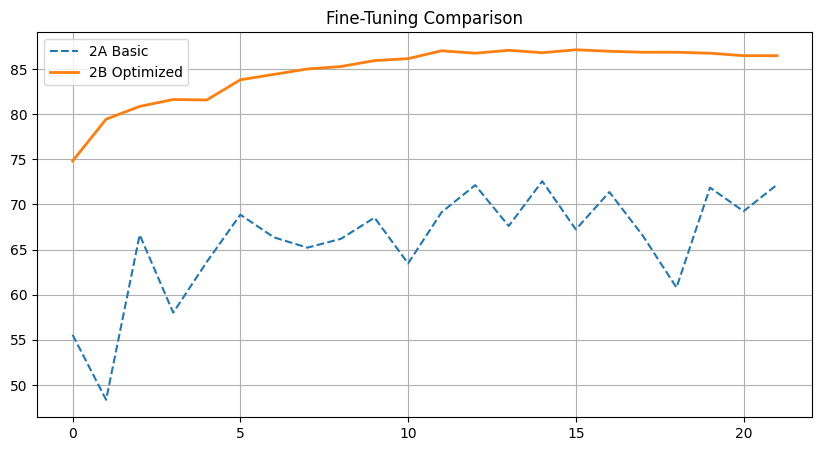

Part 2B Test Acc: 87.97%
Visualizing predictions for Part 2B model...


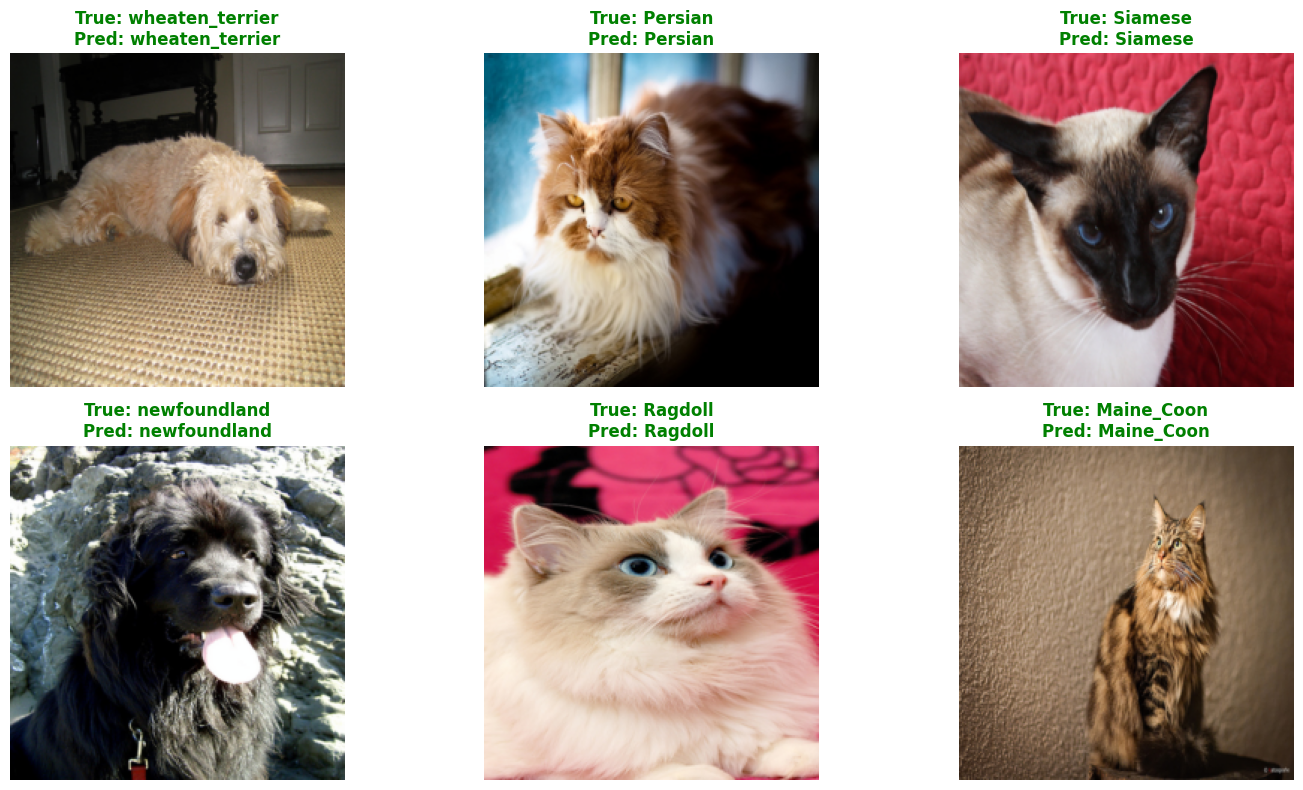

In [10]:
# Plots Parte 2
plt.figure(figsize=(10, 5))
plt.plot(hist_2a['val_acc'], label='2A Basic', linestyle='--')
plt.plot(hist_2b['val_acc'], label='2B Optimized', linewidth=2)
plt.title('Fine-Tuning Comparison')
plt.legend()
plt.grid()
plt.show()

print(f"Part 2B Test Acc: {evaluate_test(resnet_2b, test_loader):.2f}%")
print("Visualizing predictions for Part 2B model...")
visualize_predictions(resnet_2b, test_ds)